In [9]:
import time

from dateutil.parser import parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from ftx import FtxClient
from tqdm import tqdm

In [50]:
ftx = FtxClient()

# Filter perpetual futures with enough liquidity

In [3]:
df_futures = pd.DataFrame(columns=["future", "volumeUsd24h", "openInterestUsd"])

futures = ftx.get_futures()

idx = 0
for future in futures:
    if future["perpetual"] and future["volumeUsd24h"] > 1e6 and future["name"] != "USDT-PERP" and future["name"] != "UST-PERP":
        df_futures.loc[idx] = [future["name"], future["volumeUsd24h"], future["openInterestUsd"]]
        idx += 1

In [4]:
df_futures.sort_values("openInterestUsd")

future  volumeUsd24h  openInterestUsd
91   PROM-PERP  1.023854e+06     1.842509e+05
79    MTL-PERP  1.892977e+06     5.766995e+05
102    SC-PERP  1.194382e+06     5.829849e+05
118  TOMO-PERP  1.444398e+06     6.789324e+05
86    ONT-PERP  1.294187e+06     7.803665e+05
..         ...           ...              ...
12   AVAX-PERP  1.962560e+08     1.035448e+08
73   LUNA-PERP  1.163731e+08     1.246211e+08
109   SOL-PERP  4.579969e+08     2.793890e+08
47    ETH-PERP  2.104050e+09     1.081763e+09
22    BTC-PERP  3.067677e+09     1.604546e+09

[134 rows x 3 columns]

# Get future market data

In [48]:
markets = df_futures["future"].tolist()
resolution = 900 # in seconds (15, 60, 300, 900, 3600, 14400, 86400)
limit = 100 # number of points

In [51]:
df = pd.DataFrame(columns=["time"] + markets)

pbar = tqdm(markets)
for market in pbar:
    try:
        pbar.set_description(market)
        data = ftx.get_historical_data(market, resolution=resolution, limit=limit)

        closing_price = np.zeros(len(data))
        times = []

        for idx, ele in enumerate(data):
            closing_price[idx] = float(ele["close"])
            times.append(parse(ele["startTime"]))

        df[market] = closing_price
        df["time"] = times
    except ValueError as exc:
        pass

df = df.set_index("time")
markets = df.columns.to_list()

ZRX-PERP: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [01:08<00:00,  1.97it/s]


In [ ]:
df

# Analyze future data

In [11]:
def normalize_minmax(data: pd.Series):
    return (data - data.min()) / (data.max() - data.min())

def normalize_mean(data: pd.Series):
    return (data - data.mean()) / data.std()

In [ ]:
%matplotlib widget

fig, (ax, ax1, ax2) = plt.subplots(nrows=3, sharex=True)

for market in markets:
    ax.plot(df.index, df[market] / df[market][0] , "--", label=market)
    ax1.plot(df.index, normalize_mean(df[market]) , "--", label=market)
    ax2.plot(df.index, normalize_minmax(df[market]) , "--", label=market)
    
ax.set_title("First point normalized")
ax1.set_title("Mean normalized")
ax2.set_title("Min-max normalized")
fig.tight_layout()
# ax.legend()

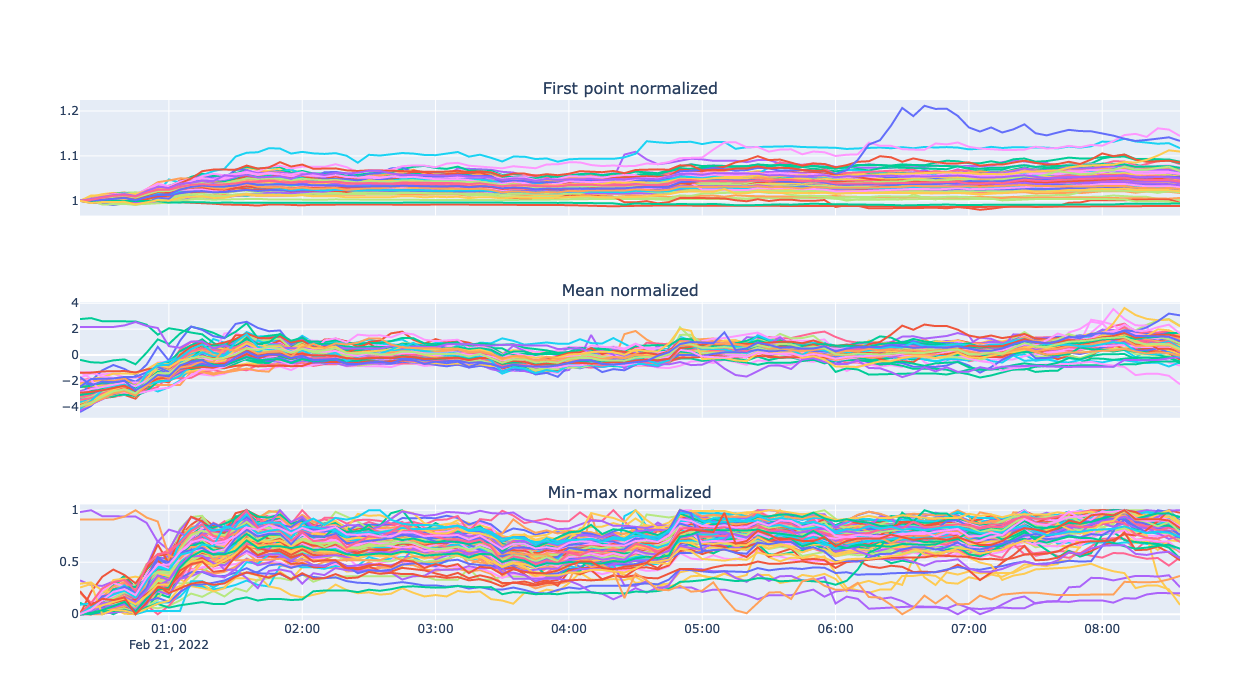

In [24]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("First point normalized", "Mean normalized", "Min-max normalized"))

for market in markets:
    name = market.split("-")[0]
    
    fig.append_trace(go.Scatter(
        x=df.index,
        y=df[market] / df[market][0], name=name, mode='lines'
    ), row=1, col=1)


    fig.append_trace(go.Scatter(
        x=df.index,
        y=normalize_mean(df[market]), name=name, mode='lines'
    ), row=2, col=1)


    fig.append_trace(go.Scatter(
        x=df.index,
        y=normalize_minmax(df[market]), name=name, mode='lines'
    ), row=3, col=1)


fig.update_layout(height=700, showlegend=False)

fig.show()

# Overall correlation with Bitcoin

In [25]:
correlate_with = "BTC-PERP"
normalization_func = normalize_mean

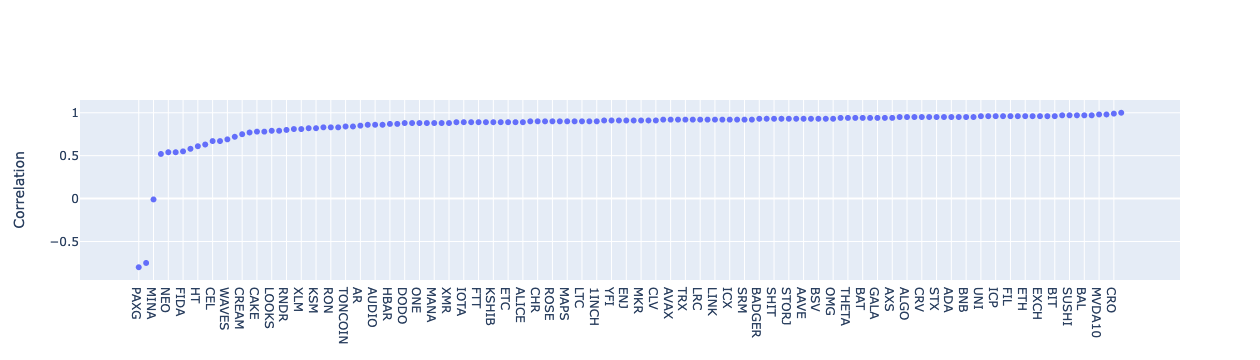

In [28]:
df_corr = pd.DataFrame(columns=["market", "correlation"])

for idx, market in enumerate(markets):
    df_corr.loc[idx] = [market.split("-")[0], round(np.corrcoef(normalization_func(df[correlate_with]), normalization_func(df[market]))[0][1], 2)]
    
df_corr = df_corr.sort_values("correlation")

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_corr.market, y=df_corr.correlation,
                    mode='markers',
                    name='markers'))
fig.update_layout(
    yaxis_title="Correlation"
)

fig.show()

# Correlation with Bitcoin

In [34]:
correlate_with = "BTC-PERP"
normalization_func = normalize_mean

MINA-PERP -75
PAXG-PERP 55
XAUT-PERP -74


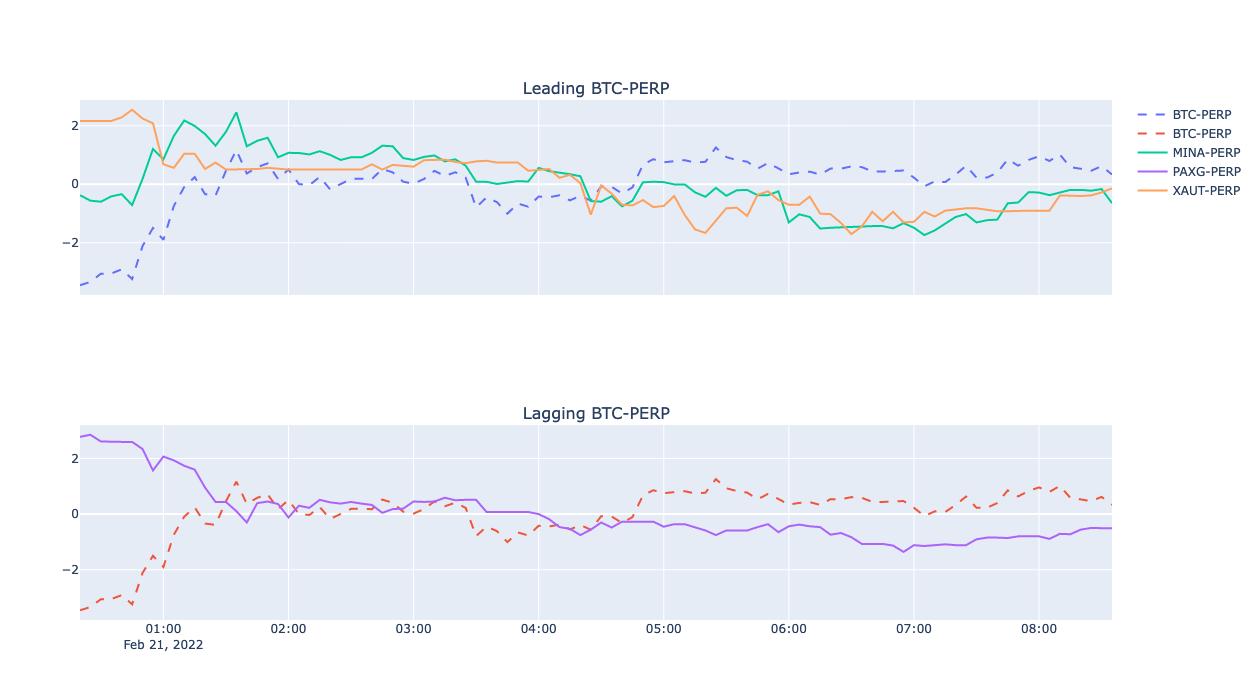

In [47]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=(f"Leading {correlate_with}", f"Lagging {correlate_with}"))

fig.append_trace(go.Scatter(
    x=df.index,
    y=normalization_func(df[correlate_with]), name=correlate_with, mode='lines',
    line = dict(shape = 'linear', dash = 'dash'),
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=df.index,
    y=normalization_func(df[correlate_with]), name=correlate_with, mode='lines',
    line = dict(shape = 'linear', dash = 'dash'),
), row=2, col=1)


for market in markets:
    corr = np.correlate(normalization_func(df[correlate_with]), normalization_func(df[market]), mode='full')
    lag = corr.argmax() - (len(df[market]) - 1)

    if abs(lag) > 5:
        lag_to_mins = lag * resolution / 60
        print(market, lag)

        if lag > 5:
            fig.append_trace(go.Scatter(
                x=df.index,
                y=normalization_func(df[market]), name=market, mode='lines'
            ), row=2, col=1)
        elif lag < -5:
            fig.append_trace(go.Scatter(
                x=df.index,
                y=normalization_func(df[market]), name=market, mode='lines'
            ), row=1, col=1)
            
fig.update_layout(height=700, width=1000)

fig.show()

MINA-PERP -75
PAXG-PERP 55
XAUT-PERP -74


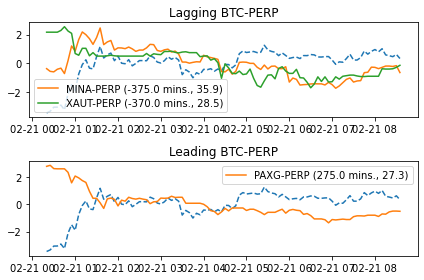

In [30]:
fig, (ax, ax1) = plt.subplots(nrows=2)

ax.plot(df.index, normalization_func(df[correlate_with]), "--")
ax1.plot(df.index, normalization_func(df[correlate_with]), "--")

for market in markets:
    corr = np.correlate(normalization_func(df[correlate_with]), normalization_func(df[market]), mode='full')
    lag = corr.argmax() - (len(df[market]) - 1)

    if abs(lag) > 5:
        lag_to_mins = lag * resolution / 60
        print(market, lag)

        if lag > 5:
            ax1.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins., {corr.max():.1f})")
        elif lag < -5:
            ax.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins., {corr.max():.1f})")

ax1.set_title(f"Leading {correlate_with}")
ax.set_title(f"Lagging {correlate_with}")

ax1.legend()
ax.legend()

fig.tight_layout()
#ax.legend()

# Correlation with Ethereum

In [ ]:
correlate_with = "ETH-PERP"
normalization_func = normalize_mean

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=2)

ax.plot(df.index, normalization_func(df[correlate_with]), "--")
ax1.plot(df.index, normalization_func(df[correlate_with]), "--")

for market in markets:
    corr = np.correlate(normalization_func(df[correlate_with]), normalization_func(df[market]), mode='full')
    lag = corr.argmax() - (len(df[market]) - 1)

    if abs(lag) > 5:
        lag_to_mins = lag * resolution / 60
        print(market, lag)

        if lag > 5:
            ax1.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins., {corr.max():.1f})")
        elif lag < -5:
            ax.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins.), {corr.max():.1f}")

ax1.set_title(f"Leading {correlate_with}")
ax.set_title(f"Lagging {correlate_with}")

#ax1.legend()
#ax.legend()

fig.tight_layout()
#ax.legend()

In [ ]:
cols = ["c", "d", "e"]

df2 = pd.DataFrame(columns=["a", "b"] + cols)
df2